In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dfWeekly = pd.read_csv("../my_data/test_weekly_109_110.csv")
dfWeekly["week"] = pd.to_datetime(dfWeekly["week"].str.split("/").str[0])

print(dfWeekly.info())
print(dfWeekly.head(3))

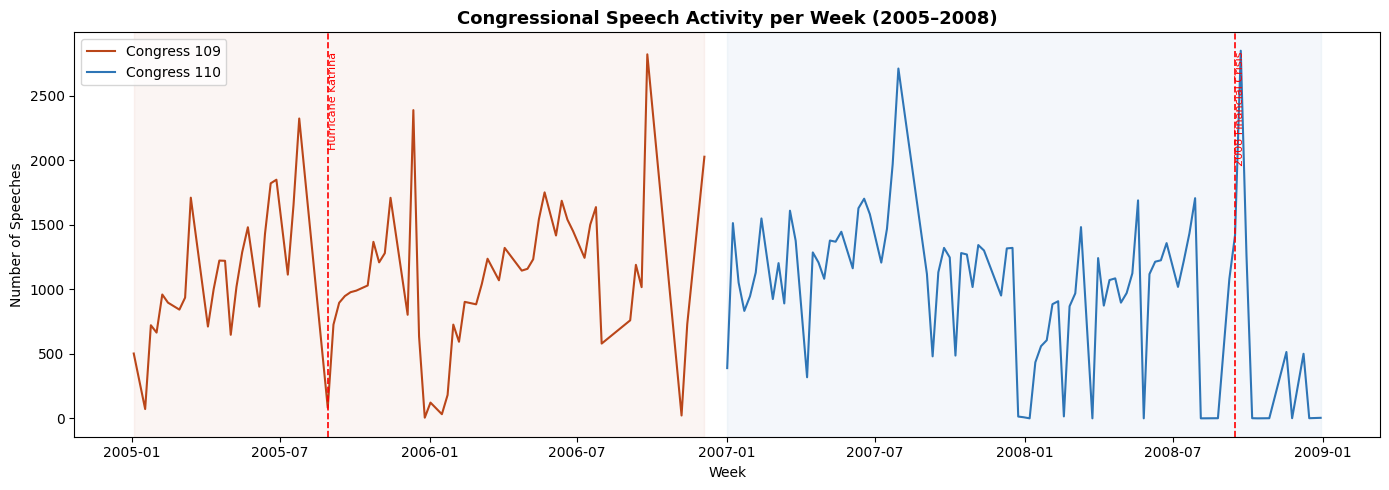

In [8]:
#speech activity plot
fig, ax = plt.subplots(figsize=(14, 5))

colors = {109: "#BA4619", 110: "#2E75B6"}
for congress, group in dfWeekly.groupby("congress"):
    ax.plot(group["week"], group["speechCount"], 
            color=colors[congress], label=f"Congress {congress}", linewidth=1.5)

# shade the two congress periods
ax.axvspan(dfWeekly[dfWeekly["congress"]==109]["week"].min(),
           dfWeekly[dfWeekly["congress"]==109]["week"].max(),
           alpha=0.05, color="#BA4619")
ax.axvspan(dfWeekly[dfWeekly["congress"]==110]["week"].min(),
           dfWeekly[dfWeekly["congress"]==110]["week"].max(),
           alpha=0.05, color="#2E75B6")

# mark known major events
events = {
    "Hurricane Katrina": "2005-08-29",
    "2008 Financial Crisis": "2008-09-15"
}
for label, date in events.items():
    ax.axvline(pd.to_datetime(date), color="red", linestyle="--", linewidth=1.2)
    ax.text(pd.to_datetime(date), ax.get_ylim()[1]*0.95, label, 
            rotation=90, fontsize=8, color="red", va="top")

ax.set_title("Congressional Speech Activity per Week (2005–2008)", fontsize=13, fontweight="bold")
ax.set_xlabel("Week")
ax.set_ylabel("Number of Speeches")
ax.legend()
plt.tight_layout()
plt.savefig("../plots/109_110_speech_activity.png", dpi=150, bbox_inches="tight")
plt.show()

In [9]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
#word frequency step 1
stopWords = set(stopwords.words('english'))

customStopWords = stopWords | {
    "would", "also", "one", "many", "new", "time", "going", "want", 
    "make", "get", "think", "know", "say", "said", "mr", "mrs", "ms",
    "senator", "speaker", "president", "gentleman", "gentlewoman",
    "colleague", "chairman", "madam", "yield", "floor", "unanimous",
    "consent", "objection", "motion", "amendment", "clause", "section",
    "congress", "congressional", "act", "legislation", "bill", "states",
    "united", "american", "state", "national", "federal", "government",
    "could", "able", "since", "people", "like", "last", "first", "every",
    "take", "today", "work", "thank", "colleagues", "committee", "house",
    "senate", "important", "need", "support", "years", "upon", "within",
    "must", "still", "well", "even", "back", "come", "good", "sure",
    "really", "much", "going", "something", "nothing", "without", "across"
}

def getTopWords(text, n=200):
    words = text.lower().split()
    words = [w for w in words if w.isalpha() and w not in customStopWords and len(w) > 3]
    return Counter(words).most_common(n)

for congress, group in dfWeekly.groupby("congress"):
    allText = " ".join(group["speech"])
    topWords = getTopWords(allText)
    print(f"\nCongress {congress} top words:")
    for word, count in topWords:
        print(f"  {word}: {count}")


Congress 109 top words:
  health: 34219
  security: 32534
  million: 28963
  percent: 27450
  country: 27340
  year: 26206
  great: 25854
  public: 25457
  made: 25003
  help: 24984
  members: 24868
  rise: 24194
  vote: 24150
  right: 23959
  believe: 23361
  care: 22503
  provide: 22099
  program: 21793
  energy: 21757
  budget: 21123
  billion: 20768
  americans: 20635
  service: 20343
  community: 19194
  world: 18953
  department: 18542
  member: 18034
  number: 17956
  continue: 17650
  money: 17559
  funding: 17524
  part: 17523
  cannot: 17498
  working: 17468
  nations: 16970
  hope: 16765
  military: 16712
  look: 16440
  children: 16349
  women: 16162
  school: 15995
  dont: 15989
  rights: 15860
  court: 15676
  administration: 15509
  america: 15371
  iraq: 15367
  small: 15116
  give: 14980
  another: 14968
  opportunity: 14871
  high: 14633
  family: 14586
  long: 14546
  issue: 14390
  including: 14388
  increase: 14275
  local: 14177
  life: 14167
  leadership: 14159


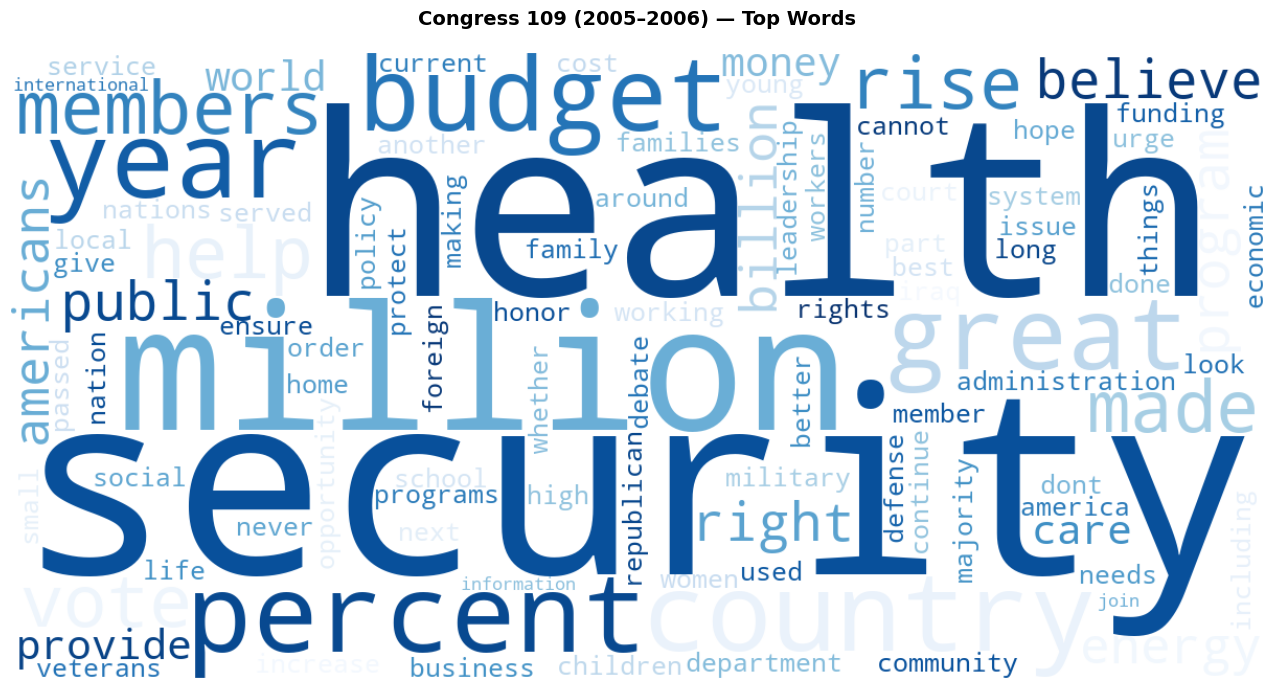

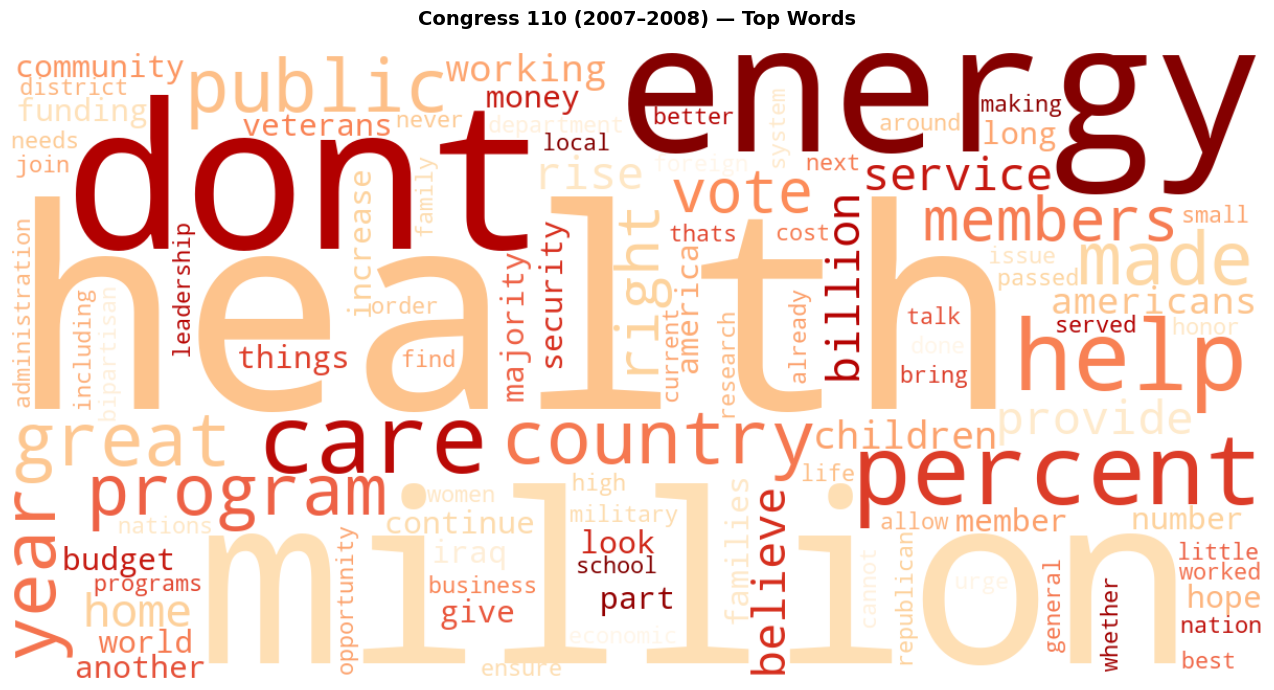

In [18]:
from wordcloud import WordCloud

def makeWordCloud(freqDict, title, filename, colormap="Blues"):
    wc = WordCloud(width=1200, height=600, background_color="white",
                   colormap=colormap, max_words=100).generate_from_frequencies(freqDict)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.show()

# congress 109
allText109 = " ".join(dfWeekly[dfWeekly["congress"]==109]["speech"].sample(20, random_state=42))
freqs109 = dict(getTopWords(allText109, n=200))
makeWordCloud(freqs109, "Congress 109 (2005–2006) — Top Words", "wordcloud_109.png", colormap="Blues")

# congress 110
allText110 = " ".join(dfWeekly[dfWeekly["congress"]==110]["speech"].sample(20, random_state=42))
freqs110 = dict(getTopWords(allText110, n=200))
makeWordCloud(freqs110, "Congress 110 (2007–2008) — Top Words", "wordcloud_110.png", colormap="OrRd")

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=list(customStopWords),
    min_df=2,
    max_df=0.85,
    token_pattern=r"(?u)\b[a-zA-Z]{4,}\b"  # only words 4+ chars, no numbers
)

tfidfMatrix = vectorizer.fit_transform(dfWeekly["speech"])
featureNames = vectorizer.get_feature_names_out()

print(f"Matrix shape: {tfidfMatrix.shape}")
print(f"Weeks x Vocabulary: {tfidfMatrix.shape[0]} x {tfidfMatrix.shape[1]}")

Matrix shape: (155, 5000)
Weeks x Vocabulary: 155 x 5000


In [20]:
import numpy as np

def getTopTfidfWords(weekIdx, n=10):
    row = tfidfMatrix[weekIdx].toarray().flatten()
    topIndices = row.argsort()[::-1][:n]
    topWords = [(featureNames[i], round(row[i], 4)) for i in topIndices]
    week = dfWeekly.iloc[weekIdx]["week"]
    print(f"\nWeek {week}:")
    for word, score in topWords:
        print(f"  {word}: {score}")

# katrina week - august 29 2005
katrineIdx = dfWeekly[dfWeekly["week"] == "2005-08-29"].index[0]

# financial crisis week - september 15 2008
crisisIdx = dfWeekly[dfWeekly["week"] == "2008-09-15"].index[0]

# random normal week for comparison
normalIdx = dfWeekly[dfWeekly["week"] == "2005-03-07"].index[0]

getTopTfidfWords(normalIdx)
getTopTfidfWords(katrineIdx)
getTopTfidfWords(crisisIdx)



Week 2005-03-07 00:00:00:
  tillie: 0.751
  debtors: 0.2716
  debts: 0.1832
  creditors: 0.1761
  amtrak: 0.1676
  jima: 0.1017
  tibetan: 0.0916
  rail: 0.0876
  median: 0.0845
  tibet: 0.0791

Week 2005-08-29 00:00:00:
  katrina: 0.6513
  orleans: 0.5307
  fema: 0.348
  levees: 0.1134
  refugees: 0.0963
  clothes: 0.0877
  catastrophe: 0.0809
  gouging: 0.08
  images: 0.0788
  evacuation: 0.0678

Week 2008-09-15 00:00:00:
  drilling: 0.4823
  drill: 0.2197
  mccain: 0.1916
  offshore: 0.1884
  freddie: 0.1676
  lakes: 0.1644
  fannie: 0.1469
  cftc: 0.1466
  theyre: 0.143
  solar: 0.1327


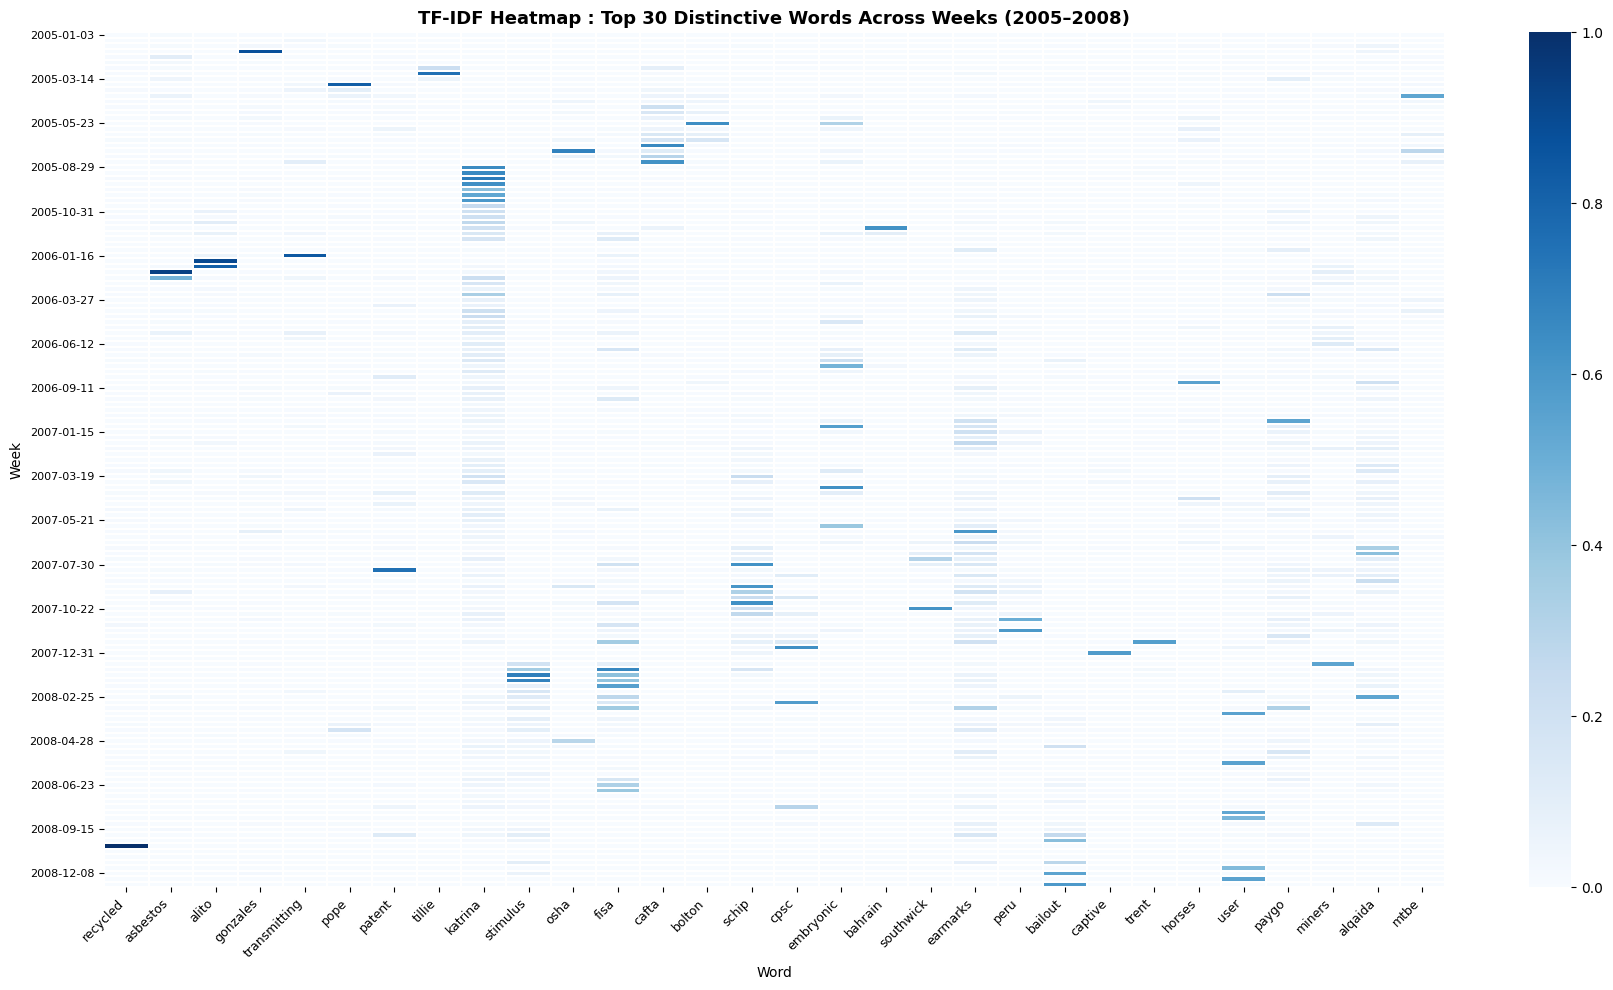

In [26]:
import seaborn as sns

# get top N words by max tfidf score across all weeks
tfidfDf = pd.DataFrame(tfidfMatrix.toarray(), 
                        columns=featureNames, 
                        index=dfWeekly["week"])

# pick top 30 words that have the highest peak tfidf score across any week
dateLabels = [str(w)[:10] for w in tfidfDf.index]

topWords = tfidfDf.max(axis=0).nlargest(30).index.tolist()
heatmapDf = tfidfDf[topWords]

fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(heatmapDf, cmap="Blues", ax=ax, linewidths=0.1, yticklabels=False)

# manually add every 8th week as a label
step = 8
tickPositions = range(0, len(tfidfDf.index), step)
ax.set_yticks([t + 0.5 for t in tickPositions])
ax.set_yticklabels([str(tfidfDf.index[t])[:10] for t in tickPositions], fontsize=8)

ax.set_title("TF-IDF Heatmap : Top 30 Distinctive Words Across Weeks (2005–2008)", 
             fontsize=13, fontweight="bold")
ax.set_xlabel("Word")
ax.set_ylabel("Week")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.tight_layout()
plt.savefig("../plots/tfidf_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

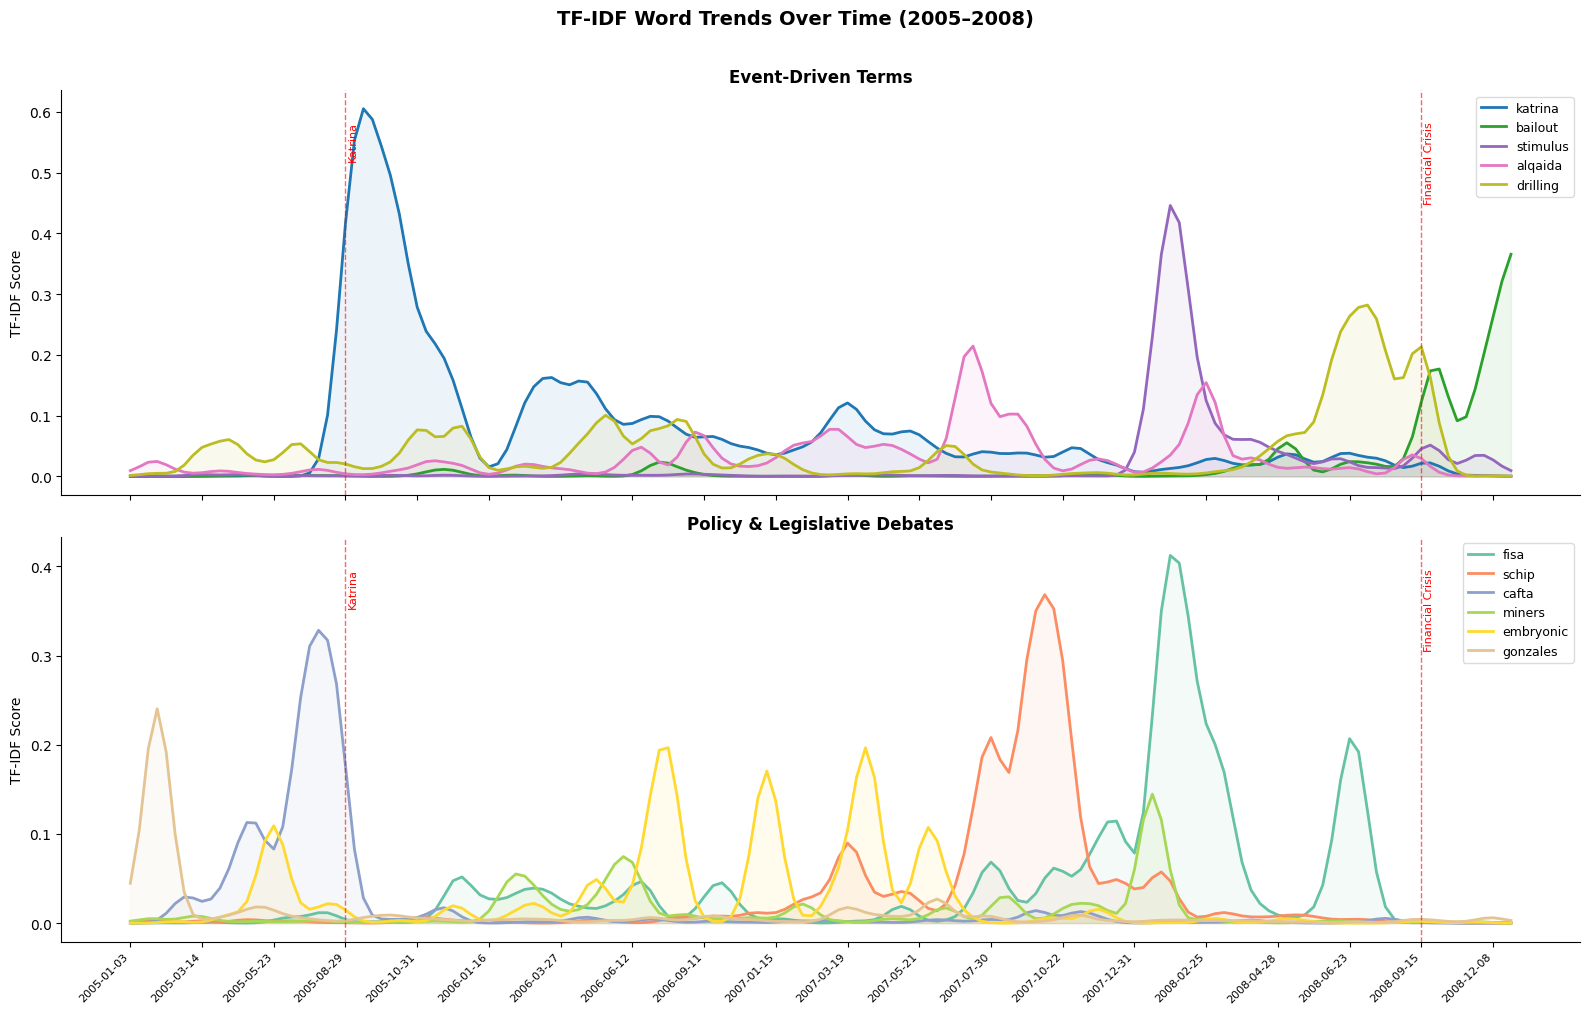

In [33]:
from scipy.ndimage import gaussian_filter1d

wordsToTrack = ["katrina", "bailout", "stimulus", "fisa", "schip", "cafta", "miners",
                "embryonic", "gonzales", "alqaida", "drilling"]

# get tfidf scores over time for each word
trackDf = tfidfDf[wordsToTrack].copy()
trackDf.index = [str(w)[:10] for w in trackDf.index]

eventWords = ["katrina", "bailout", "stimulus", "alqaida", "drilling"]
policyWords = ["fisa", "schip", "cafta", "miners", "embryonic", "gonzales"]

def smoothed(series, sigma=1.5):
    return gaussian_filter1d(series.values.astype(float), sigma=sigma)

xTicks = range(0, len(trackDf), 8)
xLabels = trackDf.index[::8]

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

titles = ["Event-Driven Terms", "Policy & Legislative Debates"]
wordSets = [eventWords, policyWords]
cmaps = [plt.cm.tab10, plt.cm.Set2]

for ax, words, title, cmap in zip(axes, wordSets, titles, cmaps):
    colors = [cmap(i / len(words)) for i in range(len(words))]
    for i, word in enumerate(words):
        ax.plot(range(len(trackDf)), smoothed(trackDf[word]),
                label=word, color=colors[i], linewidth=2)
        ax.fill_between(range(len(trackDf)), smoothed(trackDf[word]),
                        alpha=0.08, color=colors[i])
    
    for label, date in {"Katrina": "2005-08-29", "Financial Crisis": "2008-09-15"}.items():
        idx = trackDf.index.tolist().index(date)
        ax.axvline(idx, color="red", linestyle="--", linewidth=1, alpha=0.6)
        ax.text(idx + 0.3, ax.get_ylim()[1] * 0.92, label,
                fontsize=8, color="red", rotation=90, va="top")
    
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_ylabel("TF-IDF Score")
    ax.legend(loc="upper right", fontsize=9, framealpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax.set_xticks(xTicks)
ax.set_xticklabels(xLabels, rotation=45, ha="right", fontsize=8)
fig.suptitle("TF-IDF Word Trends Over Time (2005–2008)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("../plots/tfidf_wordtrends.png", dpi=150, bbox_inches="tight")
plt.show()